In [1]:
import os
import numpy as np
import matplotlib.pyplot as plt
import tifffile as tf
from scipy.ndimage import gaussian_filter
from skimage.feature import hessian_matrix, hessian_matrix_eigvals

import torch
import torchio as tio

<h3> Load Images

In [2]:
path_ventura = '/home/msst/Documents/datasets/domiki/ventura'
path_santa_rosa = '/home/msst/Documents/datasets/domiki/santa_rosa'

files = ['RED.tif', 'GRN.tif', 'BLUE.tif', 'all.tif']

<h3> Get Hessian and Grad features

In [3]:
def get_img_grad_and_hess(img, blur_sigma=0.5):
    blured = gaussian_filter(img, blur_sigma)
    grad = (np.array(np.gradient(blured))**2).sum(axis=0)**0.5
    hess = hessian_matrix(img, blur_sigma, use_gaussian_derivatives=False)
    hess_eigvals = hessian_matrix_eigvals(hess)
    return(grad, hess_eigvals)

(4418, 4573)


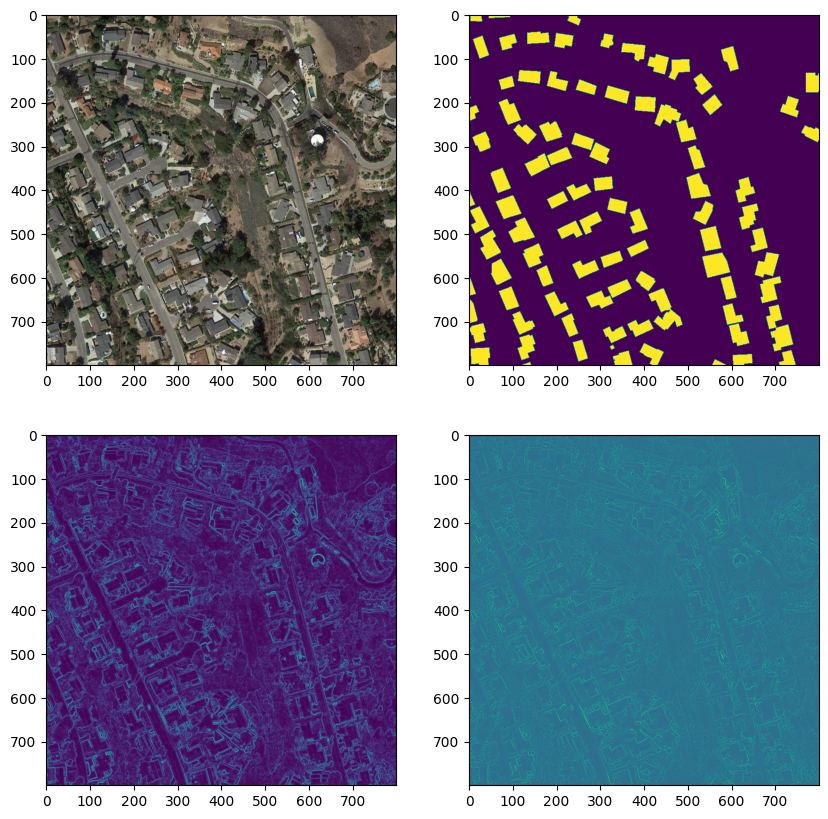

In [4]:
p = path_ventura
R = tf.imread(f'{p}/{files[0]}')
G = tf.imread(f'{p}/{files[1]}')
B = tf.imread(f'{p}/{files[2]}')
img_ventura = np.concatenate([[R],[G],[B]]).transpose((1, 2, 0))
gt_ventura = tf.imread(f'{p}/{files[3]}')

print(gt_ventura.shape)
diap = [1000, 1800]
grad_ventura, hess_ventura = get_img_grad_and_hess(img_ventura.mean(axis=2))

fig, ax = plt.subplots(2, 2, figsize=(10, 10))
im00 = ax[0][0].imshow(img_ventura[diap[0]:diap[1], diap[0]:diap[1]])
im01 = ax[0][1].imshow(gt_ventura[diap[0]:diap[1], diap[0]:diap[1]])
im10 = ax[1][0].imshow(grad_ventura[diap[0]:diap[1], diap[0]:diap[1]])
im11 = ax[1][1].imshow(hess_ventura[0][diap[0]:diap[1], diap[0]:diap[1]])

#to_test

<h3> Crop to train and test

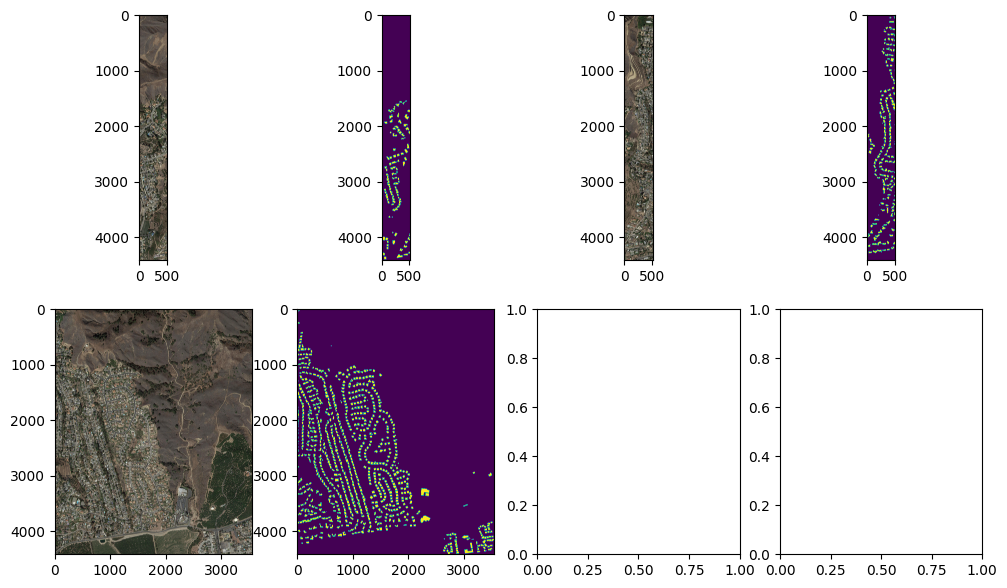

In [5]:
to_test_ventura = img_ventura[:, :512]
to_test_gt_ventura = gt_ventura[:, :512]

to_val_ventura = img_ventura[:, 512:1024]
to_val_gt_ventura = gt_ventura[:, 512:1024]

to_train_ventura = img_ventura[:, 1024:]
to_train_gt_ventura = gt_ventura[:, 1024:]

fig, ax = plt.subplots(2, 4, figsize=(12, 7))
im00 = ax[0][0].imshow(to_test_ventura)
im01 = ax[0][1].imshow(to_test_gt_ventura)
im02 = ax[0][2].imshow(to_val_ventura)
im03 = ax[0][3].imshow(to_val_gt_ventura)
im10 = ax[1][0].imshow(to_train_ventura)
im11 = ax[1][1].imshow(to_train_gt_ventura)

(2160, 2148)


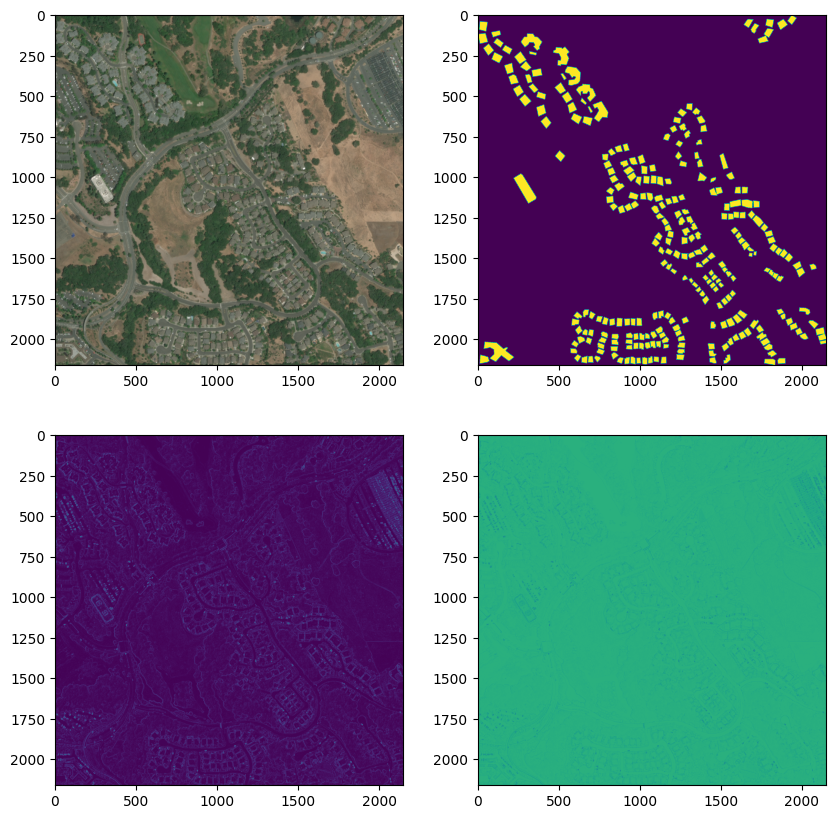

In [6]:
p = path_santa_rosa
R = tf.imread(f'{p}/{files[0]}')
G = tf.imread(f'{p}/{files[1]}')
B = tf.imread(f'{p}/{files[2]}')
img_santa_rosa = np.concatenate([[R],[G],[B]]).transpose((1, 2, 0))
gt_santa_rosa = tf.imread(f'{p}/{files[3]}')

print(gt_santa_rosa.shape)
diap = [None, None]
grad_santa_rosa, hess_santa_rosa = get_img_grad_and_hess(img_santa_rosa.mean(axis=2),
                                                         blur_sigma=0.5)

fig, ax = plt.subplots(2, 2, figsize=(10, 10))
im00 = ax[0][0].imshow(img_santa_rosa[diap[0]:diap[1], diap[0]:diap[1]])
im01 = ax[0][1].imshow(gt_santa_rosa[diap[0]:diap[1], diap[0]:diap[1]])
im10 = ax[1][0].imshow(grad_santa_rosa[diap[0]:diap[1], diap[0]:diap[1]])
im11 = ax[1][1].imshow(hess_santa_rosa[1][diap[0]:diap[1], diap[0]:diap[1]])

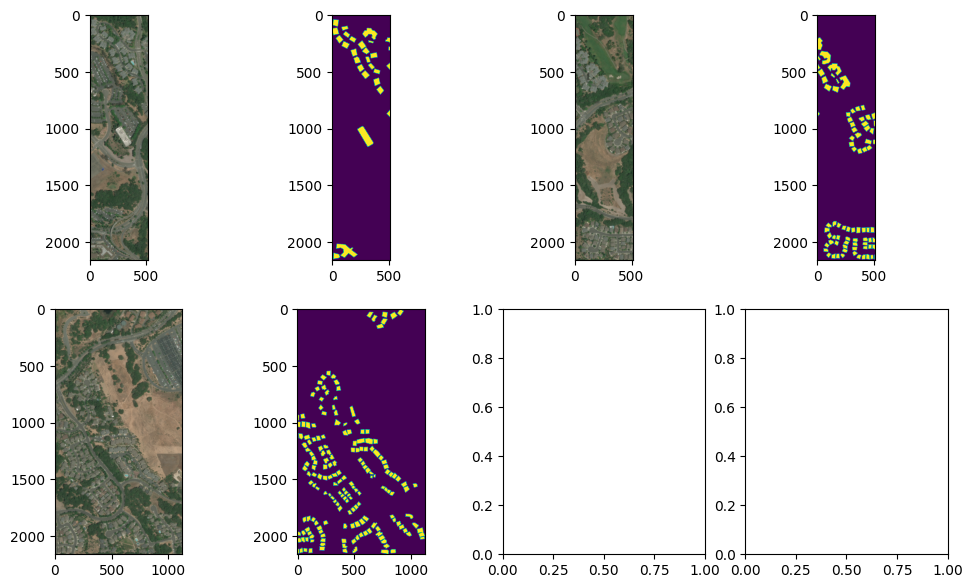

In [7]:
to_test_santa_rosa = img_santa_rosa[:, :512]
to_test_gt_santa_rosa = gt_santa_rosa[:, :512]

to_val_santa_rosa = img_santa_rosa[:, 512:1024]
to_val_gt_santa_rosa = gt_santa_rosa[:, 512:1024]

to_train_santa_rosa = img_santa_rosa[:, 1024:]
to_train_gt_santa_rosa = gt_santa_rosa[:, 1024:]

fig, ax = plt.subplots(2, 4, figsize=(12, 7))
im00 = ax[0][0].imshow(to_test_santa_rosa)
im01 = ax[0][1].imshow(to_test_gt_santa_rosa)
im02 = ax[0][2].imshow(to_val_santa_rosa)
im03 = ax[0][3].imshow(to_val_gt_santa_rosa)

im2 = ax[1][0].imshow(to_train_santa_rosa)
im3 = ax[1][1].imshow(to_train_gt_santa_rosa)

<h3> Dump data

<h5> and augmentations (rotation only)

In [8]:
def dump_data(path, name, img, gt):
    path_to_test = f"{path}/test/{name}"
    path_to_val = f"{path}/val/{name}"
    path_to_train = f"{path}/train/{name}"
    if not os.path.exists(path_to_test):
        os.mkdir(path_to_test)
    if not os.path.exists(path_to_val):
        os.mkdir(path_to_val)
    if not os.path.exists(path_to_train):
        os.mkdir(path_to_train)
    
    grad, hess = get_img_grad_and_hess(img.mean(axis=2))
    
    tensor_img = np.concatenate([img.transpose((2, 0, 1)),[grad],hess])
    tensor_img = torch.tensor(tensor_img.astype(np.float32))
    tensor_gt = torch.tensor(gt.astype(np.float32)).unsqueeze(0)
    
    to_test = tensor_img[:, :, :512]
    to_test_gt = tensor_gt[:, :, :512]
    tio.ScalarImage(tensor=to_test.unsqueeze(-1)).save(f'{path_to_test}/img.nii.gz')
    tio.LabelMap(tensor=to_test_gt.unsqueeze(-1)).save(f'{path_to_test}/label.nii.gz')
    
    to_val = tensor_img[:, :, 512:1024]
    to_val_gt = tensor_gt[:, :, 512:1024]
    tio.ScalarImage(tensor=to_val.unsqueeze(-1)).save(f'{path_to_val}/img.nii.gz')
    tio.LabelMap(tensor=to_val_gt.unsqueeze(-1)).save(f'{path_to_val}/label.nii.gz')

    to_train = tensor_img[:, :, 1024:]
    to_train_gt = tensor_gt[:, :, 1024:] 

    tio.ScalarImage(tensor=to_train.unsqueeze(-1)).save(f'{path_to_train}/img.nii.gz')
    tio.LabelMap(tensor=to_train_gt.unsqueeze(-1)).save(f'{path_to_train}/label.nii.gz')

    aug1 = lambda img: torch.flip(img, [1, 2])
    aug2 = lambda img: torch.transpose(img, 1, 2)
    aug3 = lambda img: torch.transpose(torch.flip(img, [1, 2]), 1, 2)
    augs = [aug1, aug2, aug3]
    
    for idx, aug in enumerate(augs):
        aug_path = f"{path}/train/{name}{idx}"
        if not os.path.exists(aug_path):
            os.mkdir(aug_path)
        tio.ScalarImage(tensor=aug(to_train).unsqueeze(-1)).save(f'{aug_path}/img.nii.gz')
        tio.LabelMap(tensor=aug(to_train_gt).unsqueeze(-1)).save(f'{aug_path}/label.nii.gz')



In [9]:
data_dir = '/home/msst/repo/MSRepo/Sandbox/Satelite/data'
#santa_rosa
dump_data(data_dir, 'santa_rosa', img_santa_rosa, gt_santa_rosa)
#ventura
dump_data(data_dir, 'ventura', img_ventura, gt_ventura)

<h3> Train data visualization

torch.Size([2160, 1124])
torch.Size([1124, 2160])
torch.Size([1124, 2160])
torch.Size([2160, 1124])


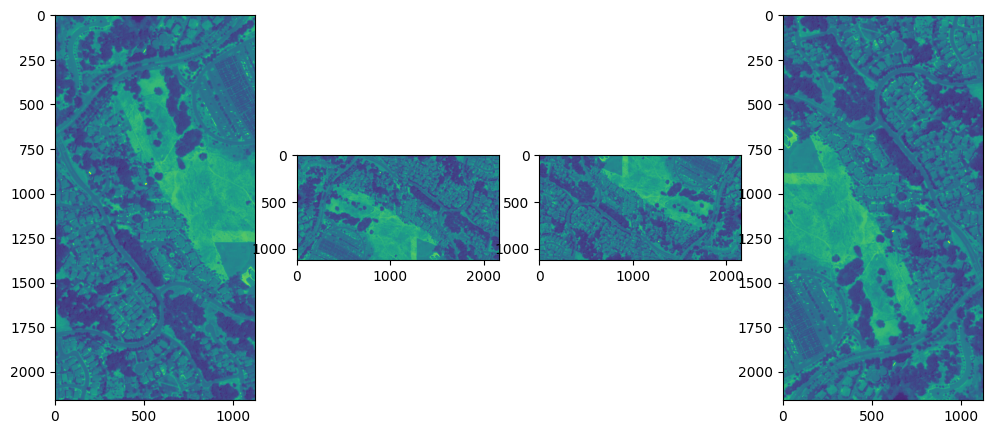

In [10]:
path = f'/home/msst/repo/MSRepo/Sandbox/Satelite/data/train/santa_rosa/img.nii.gz'
path0 = f'/home/msst/repo/MSRepo/Sandbox/Satelite/data/train/santa_rosa1/img.nii.gz'
path1 = f'/home/msst/repo/MSRepo/Sandbox/Satelite/data/train/santa_rosa2/img.nii.gz'
path2 = f'/home/msst/repo/MSRepo/Sandbox/Satelite/data/train/santa_rosa0/img.nii.gz'

paths = [path, path0, path1, path2]

fig, ax = plt.subplots(1, 4, figsize=(12, 5))
for idx, path in enumerate(paths):
    img = tio.ScalarImage(path).data[0, :, :, 0]
    print(img.shape)
    ax[idx].imshow(img)
